In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
import glob
from concurrent.futures import ThreadPoolExecutor, as_completed

# Define paths
base_folder = r"C:\Users\Manas\IoT Research Models\ODIR-5K\ODIR-5K"
training_folder = os.path.join(base_folder, "Training Images")
testing_folder = os.path.join(base_folder, "Testing Images")
preprocessed_folder = os.path.join(base_folder, "Preprocessed_Images")  # New folder
csv_path = r"C:\Users\Manas\IoT Research Models\full_df.csv"  # Input Excel file
output_xlsx_path = r"C:\Users\Manas\IoT Research Models\full_df.xlsx"  # Output Excel file

# Create the folder if it doesn't exist
os.makedirs(preprocessed_folder, exist_ok=True)

# Function to preprocess images
def preprocess_image(image_path):
    try:
        filename = os.path.basename(image_path)  # Get image filename
        save_path = os.path.join(preprocessed_folder, filename)  # New destination

        img = cv2.imread(image_path)  # Read image
        if img is None:
            print(f"⚠️ Warning: Could not load {image_path}")
            return filename, None  # Skip if image is corrupted

        img = cv2.resize(img, (224, 224))  # Resize
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = img / 255.0  # Normalize

        # Convert to uint8 (optional for saving)
        img = (img * 255).astype(np.uint8)

        # Save processed image
        cv2.imwrite(save_path, img)

        return filename, save_path  # Return new path
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return filename, None

# Find all images in both Training and Testing folders
training_images = glob.glob(os.path.join(training_folder, "*.jpg")) + glob.glob(os.path.join(training_folder, "*.png"))
testing_images = glob.glob(os.path.join(testing_folder, "*.jpg")) + glob.glob(os.path.join(testing_folder, "*.png"))
all_images = training_images + testing_images  # Merge lists

# Process images in parallel with tqdm
new_image_paths = {}
with ThreadPoolExecutor(max_workers=8) as executor:  # Use 8 threads
    futures = {executor.submit(preprocess_image, img): img for img in all_images}
    
    for future in tqdm(as_completed(futures), total=len(futures), desc="Preprocessing Images", unit="img"):
        filename, result = future.result()
        if result:
            new_image_paths[filename] = result  # Store new paths

print(f"✅ All preprocessed images saved in: {preprocessed_folder}")

# Load Excel file and update file paths
original_df = pd.read_csv(csv_path)  # Read Excel file

# Update file paths in the dataset
tqdm.pandas(desc="Updating file paths")
original_df["Left-Fundus"] = original_df["Left-Fundus"].progress_apply(lambda x: new_image_paths.get(os.path.basename(x), None) if isinstance(x, str) else x)
original_df["Right-Fundus"] = original_df["Right-Fundus"].progress_apply(lambda x: new_image_paths.get(os.path.basename(x), None) if isinstance(x, str) else x)

# Drop any rows where images are missing after preprocessing
original_df.dropna(subset=["Left-Fundus", "Right-Fundus"], inplace=True)

# Save updated dataset as an Excel file
original_df.to_excel(output_xlsx_path, index=False)
print(f"✅ New Excel file saved at: {output_xlsx_path}")


Preprocessing Images: 100%|██████████████████████████████████████████████████████| 8000/8000 [01:15<00:00, 106.45img/s]


✅ All preprocessed images saved in: C:\Users\Manas\IoT Research Models\ODIR-5K\ODIR-5K\Preprocessed_Images


Updating file paths: 100%|█████████████████████████████████████████████████████| 6392/6392 [00:00<00:00, 135998.13it/s]


✅ New Excel file saved at: C:\Users\Manas\IoT Research Models\full_df.xlsx


In [2]:
original_df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,C:\Users\Manas\IoT Research Models\ODIR-5K\ODI...,C:\Users\Manas\IoT Research Models\ODIR-5K\ODI...,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,C:\Users\Manas\IoT Research Models\ODIR-5K\ODI...,C:\Users\Manas\IoT Research Models\ODIR-5K\ODI...,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,C:\Users\Manas\IoT Research Models\ODIR-5K\ODI...,C:\Users\Manas\IoT Research Models\ODIR-5K\ODI...,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,C:\Users\Manas\IoT Research Models\ODIR-5K\ODI...,C:\Users\Manas\IoT Research Models\ODIR-5K\ODI...,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,C:\Users\Manas\IoT Research Models\ODIR-5K\ODI...,C:\Users\Manas\IoT Research Models\ODIR-5K\ODI...,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [3]:
original_df = original_df.drop(["filepath", "filename"], axis = 1)

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_fscore_support
)
import time
import logging

# --------------------- Optional: Mixed Precision ---------------------
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
# ---------------------------------------------------------------------

# --------------------- Optimizations ---------------------
AUTOTUNE = tf.data.AUTOTUNE
SHUFFLE_BUFFER = 250  # Increased for more randomness
# ---------------------------------------------------------------------

# Set up logging for any preprocessing errors
logging.basicConfig(filename="preprocessing_errors.log", level=logging.ERROR)

# Define paths
base_folder = r"C:\Users\Manas\IoT Research Models\ODIR-5K\ODIR-5K"
xlsx_path = r"C:\Users\Manas\IoT Research Models\full_df.xlsx"  # Dataset Excel file

# Load the dataset
df = pd.read_excel(xlsx_path)
labels_list = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
df['target'] = df[labels_list].idxmax(axis=1)

# Prepare image file paths and corresponding targets.
# Assumes that 'Left-Fundus' and 'Right-Fundus' columns contain preprocessed file paths.
left_paths = df['Left-Fundus'].dropna().tolist()
right_paths = df['Right-Fundus'].dropna().tolist()
all_paths = left_paths + right_paths
patient_targets = df['target'].dropna().tolist()
all_targets = patient_targets + patient_targets  # Duplicate for left & right images

# Filter out invalid paths
valid_paths = [p for p in all_paths if os.path.isfile(p)]
if len(valid_paths) == 0:
    raise ValueError("No valid images found. Please check the dataset.")

# Map textual labels to integer indices
label_to_index = {label: idx for idx, label in enumerate(labels_list)}
target_indices = [label_to_index[label] for label in all_targets]

# Split dataset into training and validation sets
X_train_paths, X_val_paths, y_train, y_val = train_test_split(
    valid_paths, target_indices, test_size=0.2, random_state=42
)
# One-hot encode labels
y_train = to_categorical(y_train, num_classes=8)
y_val = to_categorical(y_val, num_classes=8)

# --- Build tf.data Pipeline ---
IMG_SIZE = 224
BATCH_SIZE = 16  # Use a lower batch size to reduce memory usage for VGG16

def process_image(file_path, label):
    image = tf.io.read_file(file_path)
    try:
        image = tf.image.decode_jpeg(image, channels=3)
    except Exception as e:
        tf.print(f"Error decoding {file_path}: {e}")
        image = tf.zeros([IMG_SIZE, IMG_SIZE, 3], dtype=tf.uint8)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image, label

# Data augmentation: pad and random crop (similar to CIFAR10 augmentations)
def augment(image, label):
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE+20, IMG_SIZE+20)
    image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, label

def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def create_dataset(file_paths, labels, training=True):
    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    ds = ds.map(process_image, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    ds = ds.map(normalize, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.shuffle(SHUFFLE_BUFFER)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.cache().prefetch(AUTOTUNE)
    return ds

train_ds = create_dataset(X_train_paths, y_train, training=True)
val_ds = create_dataset(X_val_paths, y_val, training=False)

# Diagnostic: Check one batch
start = time.time()
for batch in train_ds.take(1):
    images_batch, labels_batch = batch
    print("One batch shape:", images_batch.shape)
end = time.time()
print("Time taken for one batch:", end - start, "seconds")

# --- Build the Model using VGG16 ---
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze the VGG16 base

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(8, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# --- Training ---
print("Starting training...")
start_time = time.time()
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)
training_time = time.time() - start_time

model.save("ocular_disease_vgg16_model.h5")
print("✅ Model saved as 'ocular_disease_vgg16_model.h5'")

# --- Evaluation ---
loss, val_accuracy = model.evaluate(val_ds, verbose=1)
print(f"✅ Validation Accuracy: {val_accuracy*100:.2f}%")

y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(np.concatenate([y for _, y in val_ds], axis=0), axis=1)

roc_score = roc_auc_score(np.concatenate([y for _, y in val_ds], axis=0), y_pred, multi_class='ovr')
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

num_params = model.count_params()
num_layers = len(model.layers)

print("\n--- Metrics for Comparative Study ---")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"ROC AUC Score: {roc_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Number of Parameters: {num_params}")
print(f"Training Time (seconds): {training_time:.2f}")
print(f"Number of Layers: {num_layers}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=labels_list))

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6
One batch shape: (16, 224, 224, 3)
Time taken for one batch: 0.20400047302246094 seconds
Starting training...
Epoch 1/50
640/640 [==============================] - 73s 102ms/step - loss: 1.5453 - accuracy: 0.3828 - val_loss: 1.3697 - val_accuracy: 0.4670 - lr: 1.0000e-04
Epoch 2/50
640/640 [==============================] - 62s 97ms/step - loss: 1.4002 - accuracy: 0.4390 - val_loss: 1.3153 - val_accuracy: 0.4853 - lr: 1.0000e-04
Epoch 3/50
640/640 [==============================] - 61s 95ms/step - loss: 1.3530 - accuracy: 0.4616 - val_loss: 1.3033 - val_accuracy: 0.4853 - lr: 1.0000e-04
Epoch 4/50
640/640 [==============================] - 61s 95ms/step - loss: 1.3134 - accuracy: 0.4794 - val_loss: 1.2864 - val_accuracy: 0.4912 - lr: 1.00

In [2]:
metrics = {
    "Accuracy": val_accuracy,
    "ROC Score": roc_score,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1_score,
    "Number of Parameters": num_params,
    "Training Time (seconds)": training_time,
    "Number of Layers": num_layers
}

# Save metrics to a CSV file
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv("Model_metrics_VGG.csv", index=False)
print("✅ Metrics saved to 'Model_metrics_VGG.csv'")

✅ Metrics saved to 'Model_metrics_VGG.csv'


Model summary saved to 'model_summary_vgg16.txt'.
Training curves saved to 'vgg16_eval.png'.


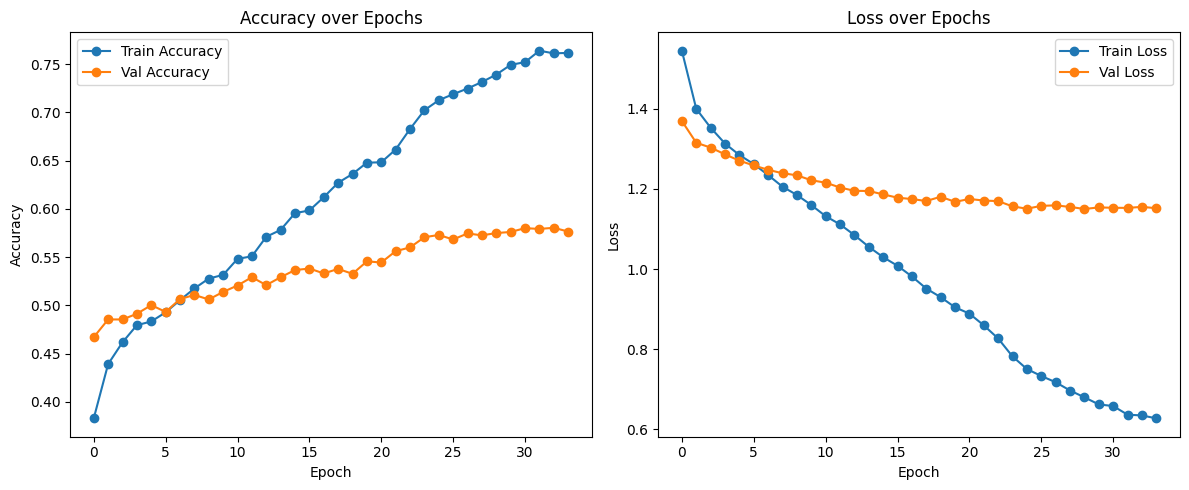

In [3]:
# Import necessary libraries
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model  # Correctly import load_model

# Load your model
model = load_model("ocular_disease_vgg16_model.h5")

# Save model summary to a text file
with open('model_summary_vgg16.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
print("Model summary saved to 'model_summary_vgg16.txt'.")

# Plot training curves
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig('vgg16_eval.png')  # Save the training curves plot
print("Training curves saved to 'vgg16_eval.png'.")
plt.show()

In [4]:
last_epoch_accuracy = history.history['accuracy'][-1]
print(f"Accuracy at the last epoch: {last_epoch_accuracy:.4f}")

Accuracy at the last epoch: 0.7617
